In [155]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from matplotlib_venn import venn2
from statsmodels.tsa.stattools import adfuller

In [156]:
url = f"https://api.bcb.gov.br/dados/serie/bcdata.sgs.21086/dados?formato=json"

response = requests.get(url)

data = response.json()
df = pd.DataFrame(data)
df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
df['valor'] = df['valor'].str.replace(',', '.').astype(float)
df.set_index('data', inplace=True)
display(df.head())
df.describe()

,valor
data,
2011-03-01,3.18
2011-04-01,3.33
2011-05-01,3.49
2011-06-01,3.42
2011-07-01,3.57


,valor
count,173.000000
mean,3.284682
std,1.092331
min,1.450000
25%,2.550000
50%,3.320000
75%,3.750000
max,5.940000


In [157]:
df.describe()

,valor
count,173.000000
mean,3.284682
std,1.092331
min,1.450000
25%,2.550000
50%,3.320000
75%,3.750000
max,5.940000


<Figure size 1200x1000 with 0 Axes>

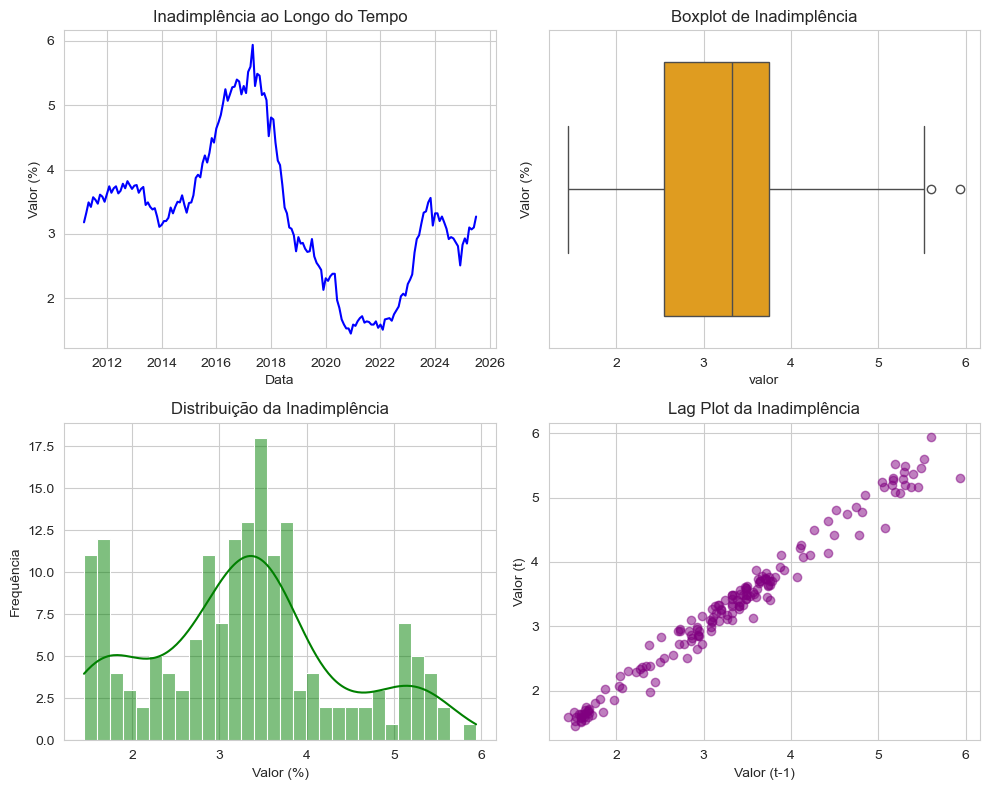

In [158]:
plt.figure(figsize=(12, 10))
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2)

# Gráfico 1: Inadimplência ao Longo do Tempo
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df.index, df['valor'], label='Inadimplência (%)', color='blue')
ax1.set_title('Inadimplência ao Longo do Tempo')
ax1.set_xlabel('Data')
ax1.set_ylabel('Valor (%)')
ax1.grid(True)

# Gráfico 2: Boxplot de Inadimplência
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(x=df['valor'], color='orange', ax=ax2)
ax2.set_title('Boxplot de Inadimplência')
ax2.set_ylabel('Valor (%)')

# Gráfico 3: Distribuição da Inadimplência
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(df['valor'], kde=True, color='green', bins=30, ax=ax3)
ax3.set_title('Distribuição da Inadimplência')
ax3.set_xlabel('Valor (%)')
ax3.set_ylabel('Frequência')

# Gráfico 4: Lag Plot
ax4 = fig.add_subplot(gs[1, 1])
pd.plotting.lag_plot(df['valor'], ax=ax4, c='purple', alpha=0.5)
ax4.set_title('Lag Plot da Inadimplência')
ax4.set_xlabel('Valor (t-1)')
ax4.set_ylabel('Valor (t)')

plt.tight_layout()
plt.show()

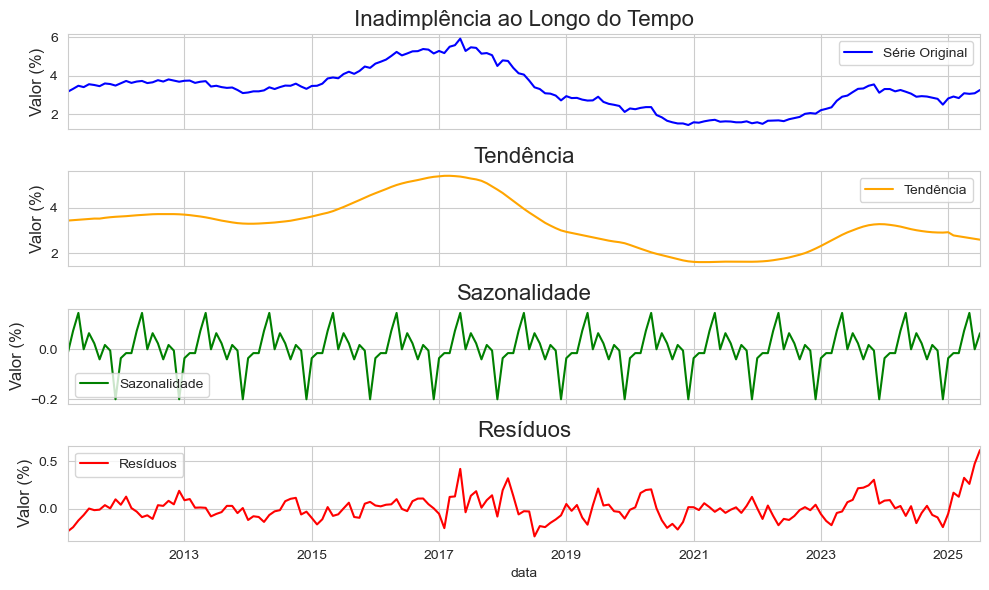

In [159]:
# Para dados mensais, o período de sazonalidade é 12
periodo = 12

# Realizando a decomposição da série temporal
decomposicao = seasonal_decompose(df['valor'], model='additive', period=periodo, extrapolate_trend='freq')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

# 1. Série Original
decomposicao.observed.plot(ax=ax1, color='b', label='Série Original')
ax1.set_ylabel('Valor (%)', fontsize=12)
ax1.set_title('Inadimplência ao Longo do Tempo', fontsize=16)
ax1.legend()

# 2. Tendência
decomposicao.trend.plot(ax=ax2, color='orange', label='Tendência')
ax2.set_ylabel('Valor (%)', fontsize=12)
ax2.set_title('Tendência', fontsize=16)
ax2.legend()

# 3. Sazonalidade
decomposicao.seasonal.plot(ax=ax3, color='g', label='Sazonalidade')
ax3.set_ylabel('Valor (%)', fontsize=12)
ax3.set_title('Sazonalidade', fontsize=16)
ax3.legend()

# 4. Resíduos
decomposicao.resid.plot(ax=ax4, color='r', label='Resíduos')
ax4.set_ylabel('Valor (%)', fontsize=12)
ax4.set_title('Resíduos', fontsize=16)
ax4.legend()

plt.tight_layout()
plt.show()

In [160]:
df['dados_diff'] = df['valor'].diff()
df['tempo'] = range(len(df))
df.head()

,valor,dados_diff,tempo
data,,,
2011-03-01,3.18,NaN,0
2011-04-01,3.33,0.15,1
2011-05-01,3.49,0.16,2
2011-06-01,3.42,-0.07,3
2011-07-01,3.57,0.15,4


In [161]:
y = df['valor']
x1 = df['tempo']
x = sm.add_constant(x1)
results = sm.OLS(y, x).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  valor   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     51.54
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           2.05e-11
Time:                        04:48:48   Log-Likelihood:                -237.46
No. Observations:                 173   AIC:                             478.9
Df Residuals:                     171   BIC:                             485.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1873      0.145     28.800      0.0

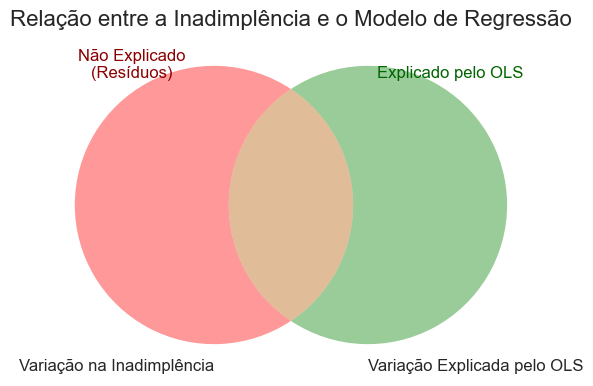

In [162]:
# Criando o diagrama de Venn com dois conjuntos
# A: Variação total na inadimplência
# B: Variação explicada pelo OLS
v = venn2(subsets=(1, 1, 0.5), set_labels=('Variação na Inadimplência', 'Variação Explicada pelo OLS'))

try:
    v.get_label_by_id('10').set_visible(False) # Área de A que não se intersecta
    v.get_label_by_id('01').set_visible(False) # Área de B que não se intersecta
    v.get_label_by_id('11').set_visible(False) # Área da interseção
except AttributeError:
    pass

# Adicionando anotações para clareza
plt.text(-0.5, 0.4, 'Não Explicado\n(Resíduos)', ha='center', fontsize=12, color='darkred')
plt.text(0.5, 0.4, 'Explicado pelo OLS', ha='center', fontsize=12, color='darkgreen')
plt.title("Relação entre a Inadimplência e o Modelo de Regressão", fontsize=16)

plt.show()

<Axes: xlabel='data'>

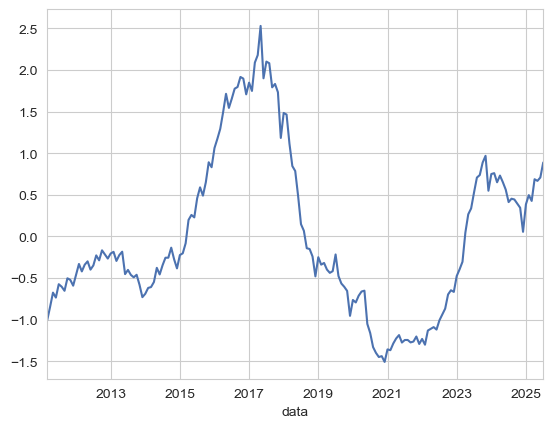

In [163]:
df['valor_sem_tend'] = results.resid
df['valor_sem_tend'].plot()

<Axes: xlabel='data'>

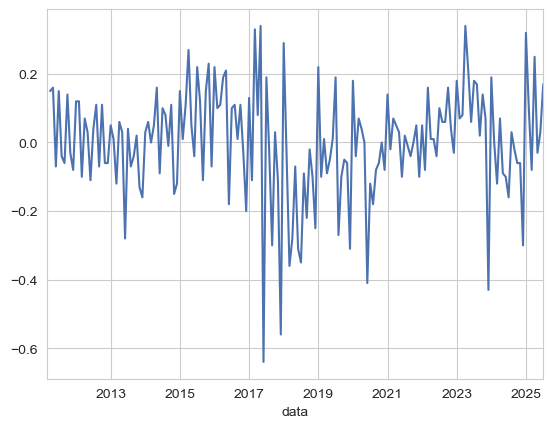

In [164]:
df['dados_diff'].plot()

In [165]:
teste_diferenciado = adfuller(df['dados_diff'].dropna())
print("Valor p:", teste_diferenciado[1])
if teste_diferenciado[1] < 0.05:
    print("Conclusão: A série é estacionária. Prossiga para a modelagem.")
else:
    print("Conclusão: A série ainda não é estacionária. Diferencie novamente ou use outra técnica.")

Valor p: 0.1443170410604238
Conclusão: A série ainda não é estacionária. Diferencie novamente ou use outra técnica.


In [166]:
df['dados_diff_2'] = df['dados_diff'].diff()
display(df)

,valor,dados_diff,tempo,valor_sem_tend,dados_diff_2
data,,,,,
2011-03-01,3.18,NaN,0,-1.007329,NaN
2011-04-01,3.33,0.15,1,-0.846833,NaN
2011-05-01,3.49,0.16,2,-0.676337,0.01
2011-06-01,3.42,-0.07,3,-0.735841,-0.23
2011-07-01,3.57,0.15,4,-0.575345,0.22
...,...,...,...,...,...
2025-03-01,2.85,-0.08,168,0.425981,-0.18
2025-04-01,3.10,0.25,169,0.686477,0.33
2025-05-01,3.07,-0.03,170,0.666973,-0.28


<Axes: xlabel='data'>

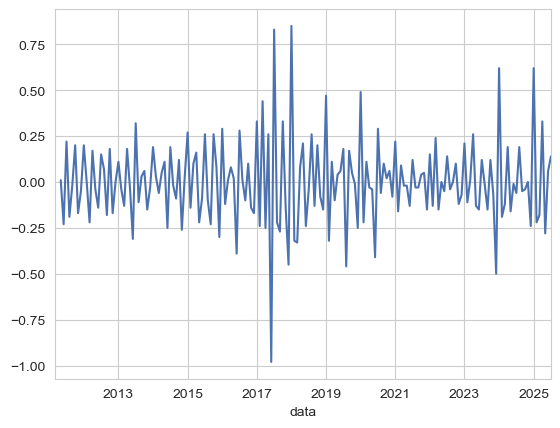

In [167]:
df['dados_diff_2'].plot()

In [168]:
teste_diferenciado = adfuller(df['dados_diff_2'].dropna())
print("Valor p:", teste_diferenciado[1])

if teste_diferenciado[1] < 0.05:
    print("Conclusão: A série é estacionária. Prossiga para a modelagem.")
else:
    print("Conclusão: A série ainda não é estacionária. Diferencie novamente ou use outra técnica.")

Valor p: 5.8882112702687375e-05
Conclusão: A série é estacionária. Prossiga para a modelagem.
